<a href="https://colab.research.google.com/github/Chiebukar/Deep-Learning/blob/main/feature_extraction_with_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d arnaudeq/cats-vs-dogs-5000

 96% 505M/527M [00:05<00:00, 76.3MB/s]
100% 527M/527M [00:06<00:00, 91.2MB/s]


In [4]:
!ls -d $PWD/*

/content/cats-vs-dogs-5000.zip	/content/kaggle.json  /content/sample_data


In [ ]:
!unzip \*.zip && rm *.zip

In [6]:
!ls -d $PWD/*

/content/dogs_cats_sample_5000	/content/kaggle.json  /content/sample_data


In [7]:
train_dir = 'dogs_cats_sample_5000/train'
validation_dir  = 'dogs_cats_sample_5000/valid'

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16

In [9]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))

58892288/58889256 [==============================] - 1s 0us/step


In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Extracting features using the pretrained convolutional base

In [11]:
datagen = ImageDataGenerator()
batch_size = 20

In [12]:
def extract_features(directory, sample_count, iter = 0):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape= (sample_count))
  generator = datagen.flow_from_directory(directory, 
                                          target_size= (150, 150),
                                          class_mode = 'binary',
                                          batch_size = batch_size
                                          )
  
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[iter*1: (iter+1) *batch_size] = features_batch
    labels[iter*1: (iter+1) *batch_size] = labels_batch
    iter+=1
    if iter*batch_size >= sample_count:
      break
    return features, labels


In [13]:
# extract features

train_features, train_labels = extract_features(train_dir, 2000)
validation_features,validation_labels = extract_features(validation_dir, 1000)

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [14]:
# flatten features
shape = 4 * 4 * 512
train_features = np.reshape(train_features, (2000, shape))
validation_features = np.reshape(validation_features, (1000, shape))

In [15]:
train_features.shape

(2000, 8192)

In [ ]:
# define dense model
model = Sequential()
model.add(Dense(256, activation='relu', input_dim = shape))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), 
              loss='binary_crossentropy', 
              metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20, 
                    validation_data=(validation_features, validation_labels))

In [17]:
acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 
epochs = range(1, len(acc) + 1)

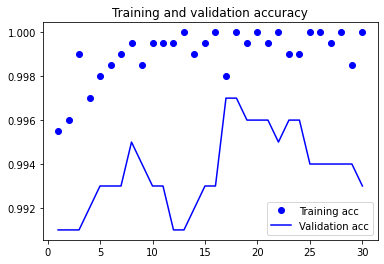

In [18]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy') 
plt.legend()

plt.show()

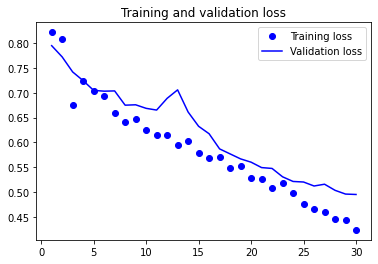

In [19]:
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend() 

plt.show()

# Feature extraction with data augmentation

connecting a dense layer to the pretrained model

In [20]:
# freeze pretrained CNN base to keep learnt wieghts
conv_base.trainable = False 

In [21]:
model_ = Sequential()
model_.add(conv_base)
model_.add(Flatten())
model_.add(Dense(256, activation='relu'))
model_.add(Dense(1, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [22]:
model_.compile(loss = 'binary_crossentropy', 
               optimizer=optimizers.RMSprop(lr=2e-5), metrics = ['acc']  )

In [23]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, 
                                   width_shift_range=0.2, height_shift_range=0.2, 
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True, 
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

In [24]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    target_size =(150, 150),
                                                    class_mode = 'binary'
                                                    )
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                    batch_size = 20,
                                                    target_size =(150, 150),
                                                    class_mode = 'binary'
                                                    )

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
history = model_.fit(train_generator, steps_per_epoch=100, 
                              epochs=30, validation_data=validation_generator, 
                              validation_steps=50)

In [26]:
acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 
epochs = range(1, len(acc) + 1)

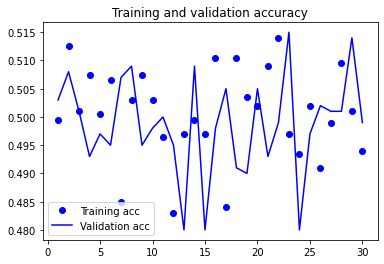

In [27]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy') 
plt.legend()

plt.show()

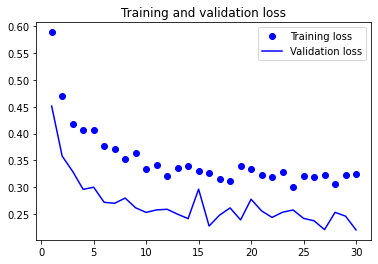

In [28]:
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend() 

plt.show()

appears to be underfitting and requires a stronger network

Fine Tuning

In [29]:
# unfreezing some layers of the CNN base
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable == True:
    layer.trainable = True
  else:
    layer.trainable = False

In [30]:
model_.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

In [ ]:
history = model_.fit( train_generator, steps_per_epoch=100, epochs=100, 
                              validation_data=validation_generator, validation_steps=50)

In [32]:
acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 
epochs = range(1, len(acc) + 1)

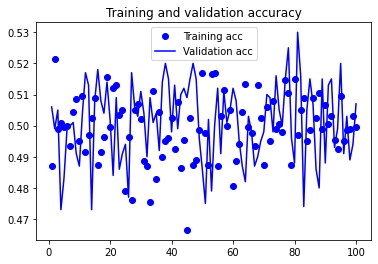

In [33]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy') 
plt.legend()

plt.show()

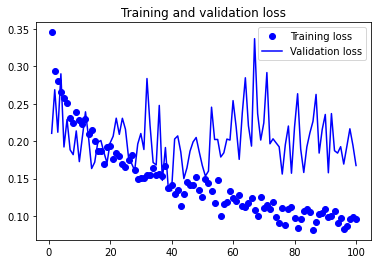

In [34]:
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend() 

plt.show()

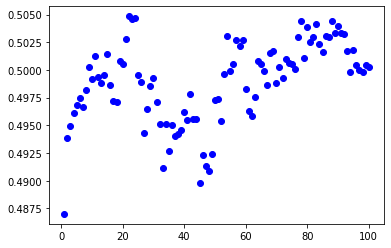

In [36]:
def smooth_curve(points, factor=0.8): 
  smoothed_points = [] 
  for point in points: 
    if smoothed_points: 
      previous = smoothed_points[-1] 
      smoothed_points.append(previous * factor + point * (1 - factor)) 
    else: smoothed_points.append(point) 
  return smoothed_points
  
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
    
  

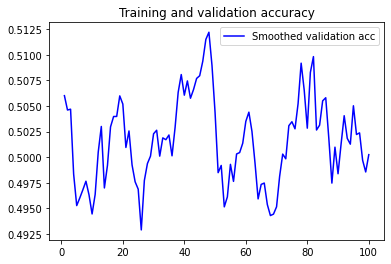

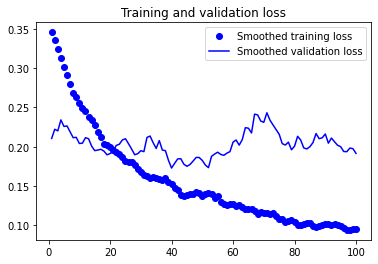

In [39]:
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc') 
plt.title('Training and validation accuracy') 
plt.legend() 

plt.figure() 

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss') 
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss') 
plt.title('Training and validation loss') 
plt.legend() 

plt.show()